In [103]:
# System imports.
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# LGBM
from lightgbm import LGBMClassifier

# Optuna
import optuna
# from optuna.integration import lightgbm as lgb

In [7]:
df_fs1 = pd.read_csv(os.path.join("data_subset", "FS1.txt"), sep="\t", header=None)
# 10 Hz
df_fs1.columns = df_fs1.columns / 10.
df_fs1

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,59.0,59.1,59.2,59.3,59.4,59.5,59.6,59.7,59.8,59.9
0,8.990,0.770,0.641,0.006,0.000,0.000,0.001,0.003,0.001,0.001,...,7.743,7.992,7.919,7.773,7.955,7.823,7.963,7.876,7.738,8.036
1,8.919,0.815,0.709,0.009,0.004,0.000,0.001,0.000,0.000,0.001,...,7.831,8.003,7.923,7.745,7.867,7.747,7.969,7.969,7.963,7.890
2,9.179,0.683,0.528,0.008,0.003,0.001,0.003,0.003,0.004,0.006,...,7.862,7.815,7.894,7.743,7.936,7.770,7.982,7.873,7.898,7.952
3,9.034,0.728,0.595,0.009,0.001,0.004,0.003,0.003,0.003,0.001,...,7.631,7.949,7.773,8.054,7.827,8.011,7.919,7.938,7.877,7.773
4,8.729,0.705,0.446,0.014,0.007,0.003,0.001,0.003,0.001,0.000,...,7.771,7.936,7.919,7.946,7.804,7.983,7.838,7.882,7.894,7.825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,8.173,1.024,0.834,0.009,0.000,0.001,0.000,0.003,0.001,0.000,...,7.904,7.777,7.938,7.841,7.741,8.004,7.869,7.719,8.003,7.874
2201,8.317,0.883,0.799,0.008,0.005,0.000,0.000,0.000,0.000,0.001,...,7.766,7.957,7.817,7.739,8.036,7.871,7.647,7.993,7.898,7.787
2202,8.170,0.686,0.583,0.011,0.000,0.003,0.004,0.000,0.000,0.000,...,7.898,7.648,7.953,7.871,7.859,7.921,7.770,7.982,7.859,7.685
2203,8.496,0.543,0.366,0.009,0.005,0.000,0.000,0.000,0.001,0.003,...,7.834,7.737,8.065,7.893,7.653,7.971,7.898,7.758,7.892,7.793


In [8]:
df_ps2 = pd.read_csv(os.path.join("data_subset", "PS2.txt"), sep="\t", header=None)
# 100 Hz
df_ps2.columns = df_ps2.columns / 100.
df_ps2

,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,59.90,59.91,59.92,59.93,59.94,59.95,59.96,59.97,59.98,59.99
0,125.50,125.39,125.40,125.03,124.05,123.18,104.01,56.500,23.992,18.406,...,125.02,125.00,125.10,125.09,124.98,124.91,124.98,125.11,125.14,125.10
1,125.06,125.08,125.09,124.69,123.84,123.14,103.63,63.687,28.359,21.711,...,124.80,124.88,125.13,125.22,125.09,124.98,125.06,125.13,125.09,125.04
2,125.13,125.27,125.23,124.74,123.94,123.23,106.35,60.516,26.258,19.258,...,124.61,124.69,124.74,124.71,124.59,124.64,124.74,124.73,124.77,124.88
3,124.93,124.96,124.92,124.41,123.60,122.88,103.99,58.859,27.781,21.469,...,124.82,124.79,124.69,124.69,124.77,124.83,124.69,124.53,124.51,124.59
4,124.72,124.74,124.66,124.31,123.57,122.74,105.94,62.648,30.875,23.883,...,124.80,124.67,124.49,124.56,124.69,124.62,124.45,124.41,124.47,124.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,125.47,125.63,125.70,125.34,124.94,124.88,113.56,71.586,34.516,25.531,...,125.57,125.51,125.38,125.43,125.59,125.61,125.53,125.50,125.60,125.73
2201,125.83,125.70,125.59,125.43,125.18,124.98,114.30,72.531,35.234,26.820,...,125.86,125.77,125.74,125.81,125.77,125.66,125.58,125.58,125.55,125.44
2202,125.41,125.49,125.63,125.38,124.96,124.77,113.69,70.773,32.531,23.773,...,125.66,125.73,125.77,125.81,125.94,126.04,125.98,125.84,125.84,125.94
2203,125.91,125.73,125.59,125.38,125.10,124.96,114.19,74.039,38.695,30.125,...,125.55,125.56,125.58,125.74,125.84,125.73,125.66,125.73,125.86,125.91


In [31]:
df_profile = pd.read_csv(os.path.join("data_subset", "profile.txt"), sep="\t", header=None)
df_profile.columns = [
    "Cooler condition (%)", "Valve condition (%)", "Internal pump leakage",
    "Hydraulic accumulator (bar)", "stable flag"
]
df_profile

,Cooler condition (%),Valve condition (%),Internal pump leakage,Hydraulic accumulator (bar),stable flag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1
...,...,...,...,...,...
2200,100,100,0,90,0
2201,100,100,0,90,0
2202,100,100,0,90,0
2203,100,100,0,90,0


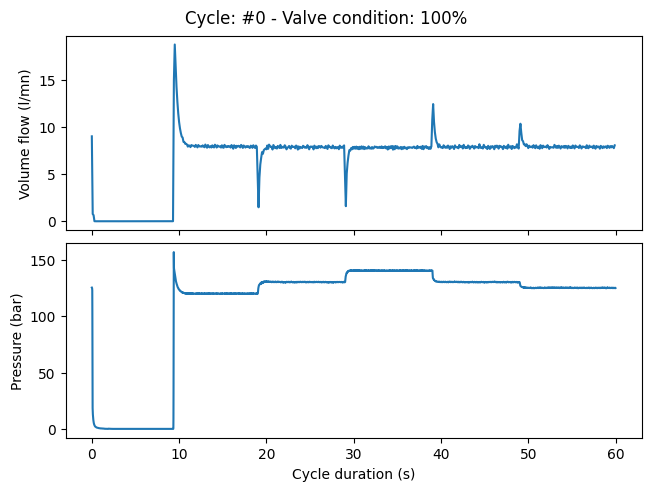

In [24]:
def plot_cycle(index):
    fig, axs = plt.subplots(2, 1, constrained_layout=True, sharex=True)
    df_fs1.iloc[index].plot(ax=axs[0])
    axs[0].set_ylabel("Volume flow (l/mn)")
    df_ps2.iloc[index].plot(ax=axs[1])
    axs[1].set_ylabel("Pressure (bar)")
    axs[1].set_xlabel("Cycle duration (s)")
    valve_condition = df_profile.loc[index, "Valve condition (%)"]
    fig.suptitle(f"Cycle: #{index} - Valve condition: {valve_condition}%")
    plt.show()

plot_cycle(0)

In [109]:
def processings(data_fs1, data_ps2, target, tools=None, n_components=2):
    # multiple dataset
    if tools is None:
        pca_fs1 = PCA(n_components=n_components)
        pca_fs1.fit(data_fs1.to_numpy(np.float32))
        pca_ps2 = PCA(n_components=n_components)
        pca_ps2.fit(data_ps2.to_numpy(np.float32))
    else:
        pca_fs1 = tools["pca"]["fs1"]
        pca_ps2 = tools["pca"]["ps2"]
    X_fs1 = pca_fs1.transform(data_fs1.to_numpy(np.float32))
    X_ps2 = pca_ps2.transform(data_ps2.to_numpy(np.float32))
    X = np.hstack([X_fs1, X_ps2])
    
    # Ordonned features
    encoder = {100: 3, 90: 2, 80: 1, 73: 0}
    y = target.map(encoder).to_numpy(int)
    return X, y, {"pca": {"fs1": pca_fs1, "ps2": pca_ps2}}

def plot_pca(X_train, X_test, y_train, y_test):
    fig, axs = plt.subplots(
        2, 2, constrained_layout=True, sharex="col", sharey="col"
    )
    y_unique = [0, 1, 2, 3]
    decoder = {3: 100, 2: 90, 1: 80, 0: 73}
    palette = sns.color_palette(n_colors=len(y_unique))
    for color, y_value in zip(palette, y_unique):
        axs[0, 0].scatter(
            X_train[y_train==y_value, 0], X_train[y_train==y_value, 1],
            color=color, label=f"{decoder[y_value]}%"
        )
        axs[1, 0].scatter(
            X_test[y_test==y_value, 0], X_test[y_test==y_value, 1],
            color=color, label=f"{decoder[y_value]}%"
        )
        axs[0, 1].scatter(
            X_train[y_train==y_value, 2], X_train[y_train==y_value, 3],
            color=color, label=f"{decoder[y_value]}%"
        )
        axs[1, 1].scatter(
            X_test[y_test==y_value, 2], X_test[y_test==y_value, 3],
            color=color, label=f"{decoder[y_value]}%"
        )
    axs[0, 0].set_title("Training set | FS1")
    axs[0, 1].set_title("Training set | PS2")
    axs[1, 0].set_title("Testing set | FS1")
    axs[1, 1].set_title("Testing set | PS2")
    axs[0, 0].legend(title="Valve condition")
    axs[0, 1].legend(title="Valve condition")
    axs[1, 0].legend(title="Valve condition")
    axs[1, 1].legend(title="Valve condition")
    plt.show()

def prepare_data(data_fs1, data_ps2, data_profile, idx_train=2000):
    X_train, y_train, training_tools = processings(
        df_fs1.iloc[:idx_train], df_ps2.iloc[:idx_train],
        df_profile["Valve condition (%)"].iloc[:idx_train]
    )
    X_test, y_test, _ = processings(
        df_fs1.iloc[idx_train:], df_ps2.iloc[idx_train:],
        df_profile["Valve condition (%)"].iloc[idx_train:],
        tools=training_tools
    )
    return X_train, X_test, y_train, y_test, training_tools

In [110]:
class Model(object):
    def __init__(self, pca_fs1, pca_ps2, clf):
        self.model_clf = None
        self.pca_fs1 = pca_fs1
        self.pca_ps2 = pca_ps2
        self.clf = clf
        self.encoder = {100: 3, 90: 2, 80: 1, 73: 0}
        self.decoder = {3: 100, 2: 90, 1: 80, 0: 73}

    def _process_data(X_fs1, X_ps2):
        # Features
        X = np.hstack([
            self.pca_fs1.transform(X_fs1.astype(np.float32)),
            self.pca_ps2.transform(X_ps2.astype(np.float32))
        ])
        return X

    def predict(self, X_fs1, X_ps2):
        X = self._process_data(X_fs1, X_ps2)
        y = self.clf.predict(X)
        y = np.array([self.decoder[y_val] for y_val in y])
        return y

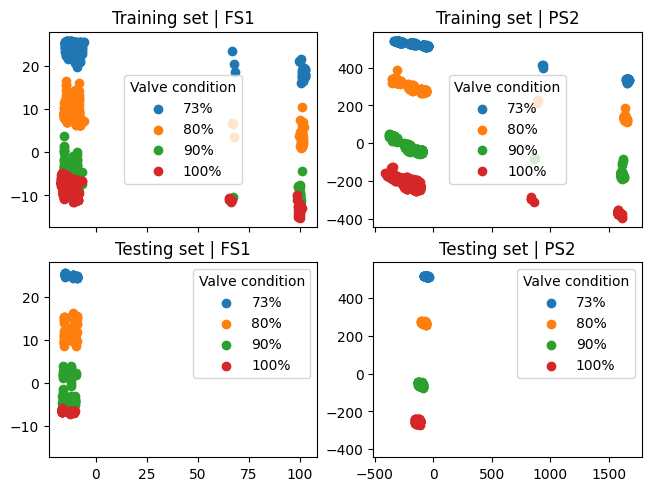

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 4
[LightGBM] [Info] Start training from score -1.832581
[LightGBM] [Info] Start training from score -1.838851
[LightGBM] [Info] Start training from score -1.864330
[LightGBM] [Info] Start training from score -0.642454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
                            precision    recall  f1-score   support

optimal switching behavior       1.00      1.00      1.00      1052
                 small lag       1.00      1.00      1.00       310
                severe lag       1.00      1.00      1.00       318

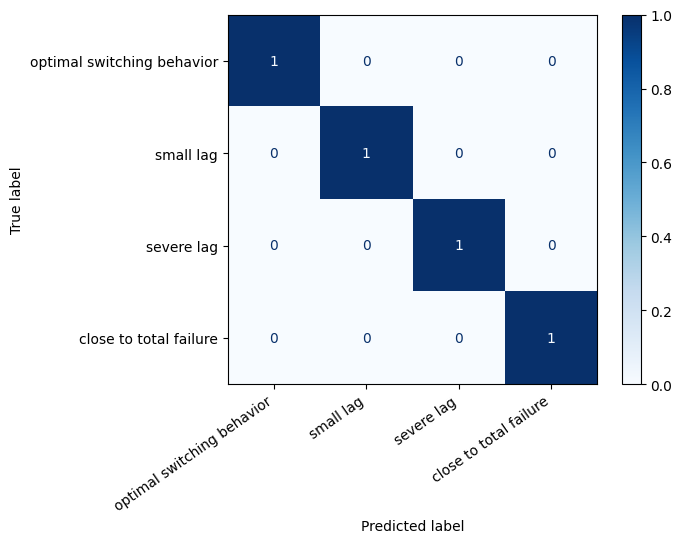

In [111]:
def pipeline(data_fs1, data_ps2, data_profile, idx_train=2000):
    X_train, X_test, y_train, y_test, training_tools = prepare_data(
        data_fs1, data_ps2, data_profile, idx_train=idx_train
    )
    plot_pca(X_train, X_test, y_train, y_test)
    
    clf = LGBMClassifier(random_state=0, num_leaves=11, learning_rate=0.05)
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    labels = [3, 2, 1, 0]
    target_names = [
        "optimal switching behavior", "small lag", "severe lag",
        "close to total failure"
    ]
    print(classification_report(
        y_train, y_train_pred, labels=labels, target_names=target_names
    ))
    print(classification_report(
        y_test, y_test_pred, labels=labels, target_names=target_names
    ))

    fig, axs = plt.subplots(1, 1)
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred, labels=labels, display_labels=target_names,
        cmap="Blues", normalize="true", ax=axs
    )
    axs.set_xticks(axs.get_xticks(), axs.get_xticklabels(), rotation=35, ha='right')

    # Save the model
    model = Model(training_tools["pca"]["fs1"], training_tools["pca"]["ps2"], clf)
    with open("model.bin", "wb") as f:
        pickle.dump(model, f)
    
pipeline(df_fs1, df_ps2, df_profile, idx_train=2000)